In [ ]:
# Import libraries

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

# Data

In [ ]:
# Get column names

cols = ['ViolentCrimesPerPop'] # Target variable is first column in the data

with open(path_to_data+'communities.names', 'r') as f:
    lines = f.readlines()

for line in lines:
    if '@attribute ' in line:
        words = line.split()
        cols.append(words[1])

cols.pop() # Remove target variable name from the end
len(cols)

128

In [ ]:
# Read data

df = pd.read_csv(path_to_data + 'crime_prep.txt', sep=",")
df.columns = cols
df.drop('fold', axis=1, inplace=True)
df

,ViolentCrimesPerPop,state,county,community,communityname,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,...,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
0,0.20,8,NaN,NaN,Lakewoodcity,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,...,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.00,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14
1,0.67,53,NaN,NaN,Tukwilacity,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,...,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.00,0.21,0.50,0.34,0.60,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN
2,0.43,24,NaN,NaN,Aberdeentown,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,...,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.00,0.14,0.49,0.54,0.67,0.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN
3,0.12,34,5.0,81440.0,Willingborotownship,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,...,0.75,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.00,0.19,0.30,0.73,0.64,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN
4,0.03,42,95.0,6096.0,Bethlehemtownship,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,...,0.40,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.00,0.11,0.72,0.64,0.61,0.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.09,12,NaN,NaN,TempleTerracecity,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,0.03,1.0,0.42,0.74,0.14,0.64,0.30,0.06,0.46,0.41,0.49,0.50,0.27,0.00,0.16,0.36,0.52,0.01,0.16,0.08,0.11,0.65,0.12,0.71,0.17,...,0.45,0.39,0.41,0.41,0.50,0.48,0.39,0.00,0.00,0.22,0.28,0.34,0.48,0.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN
1990,0.45,6,NaN,NaN,Seasidecity,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,0.06,1.0,0.28,0.76,0.10,0.30,0.26,0.37,0.48,0.24,0.18,0.20,0.26,0.18,0.20,0.23,0.26,0.04,0.32,0.33,0.37,0.22,0.24,0.77,0.10,...,0.54,0.54,0.61,0.5

In [ ]:
# Most of the features (other than state, county and community) are normalized.
# communityname is the only feature with string values.

df.describe()

,ViolentCrimesPerPop,state,county,community,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,...,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
count,1994.000000,1994.000000,820.000000,817.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1993.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,...,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,1994.000000,1994.000000,1994.000000,319.000000,319.000000,319.000000,319.000000,1994.000000,319.000000
mean,0.237979,28.683551,58.826829,46188.336597,0.057593,0.463395,0.179629,0.753716,0.153681,0.144022,0.424218,0.493867,0.336264,0.423164,0.064072,0.696269,0.361123,0.558154,0.291570,0.495687,0.471133,0.317778,0.479248,0.375677,0.350251,0.368049,0.291098,0.203506,0.322357,0.284742,0.386279,0.055507,0.303024,0.315807,0.383330,0.361675,0.363531,0.501073,0.396384,0.440597,...,0.346379,0.372457,0.422964,0.384102,0.490125,0.449754,0.403816,0.029438,0.022778,0.215552,0.608892,0.535050,0.626424,0.651530,0.069655,0.217461,0.924734,0.246332,0.097994,0.215204,0.343636,0.217492,0.689404,0.726959,0.220470,0.134859,0.114859,0.259185,0.075549,0.556050,0.305987,0.065231,0.232854,0.161685,0.163103,0.076708,0.698589,0.440439,0.094052,0.195078
std,0.232985,16.397553,126.420560,25299.726569,0.126906,0.163717,0.253442,0.244039,0.208877,0.232492,0.155196,0.143564,0.166505,0.179185,0.128256,0.444811,0.209362,0.182913,0.204108,0.178071,0.173619,0.222137,0.167564,0.198257,0.191109,0.186804,0.171593,0.164775,0.195411,0.191008,0.183081,0.127941,0.228474,0.213360,0.202508,0.209193,0.202171,0.174036,0.202386,0.175457,...,0.219323,0.209278,0.248286,0.213404,0.169500,0.187274,0.192593,0.102607,0.100400,0.231134,0.204329,0.181352,0.200521,0.198221,0.138238,0.159928,0.132249,0.155045,0.161927,0.164622,0.197181,0.159941,0.226811,0.221409,0.236271,0.196188,0.227348,0.225655,0.120153,0.203178,0.226884,0.109459,0.203092,0.229055,0.214778,0.140207,0.213944,0.405808,0.240328,0.164718
min,0.000000,1.000000,1.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

# Correlation between features and target variable

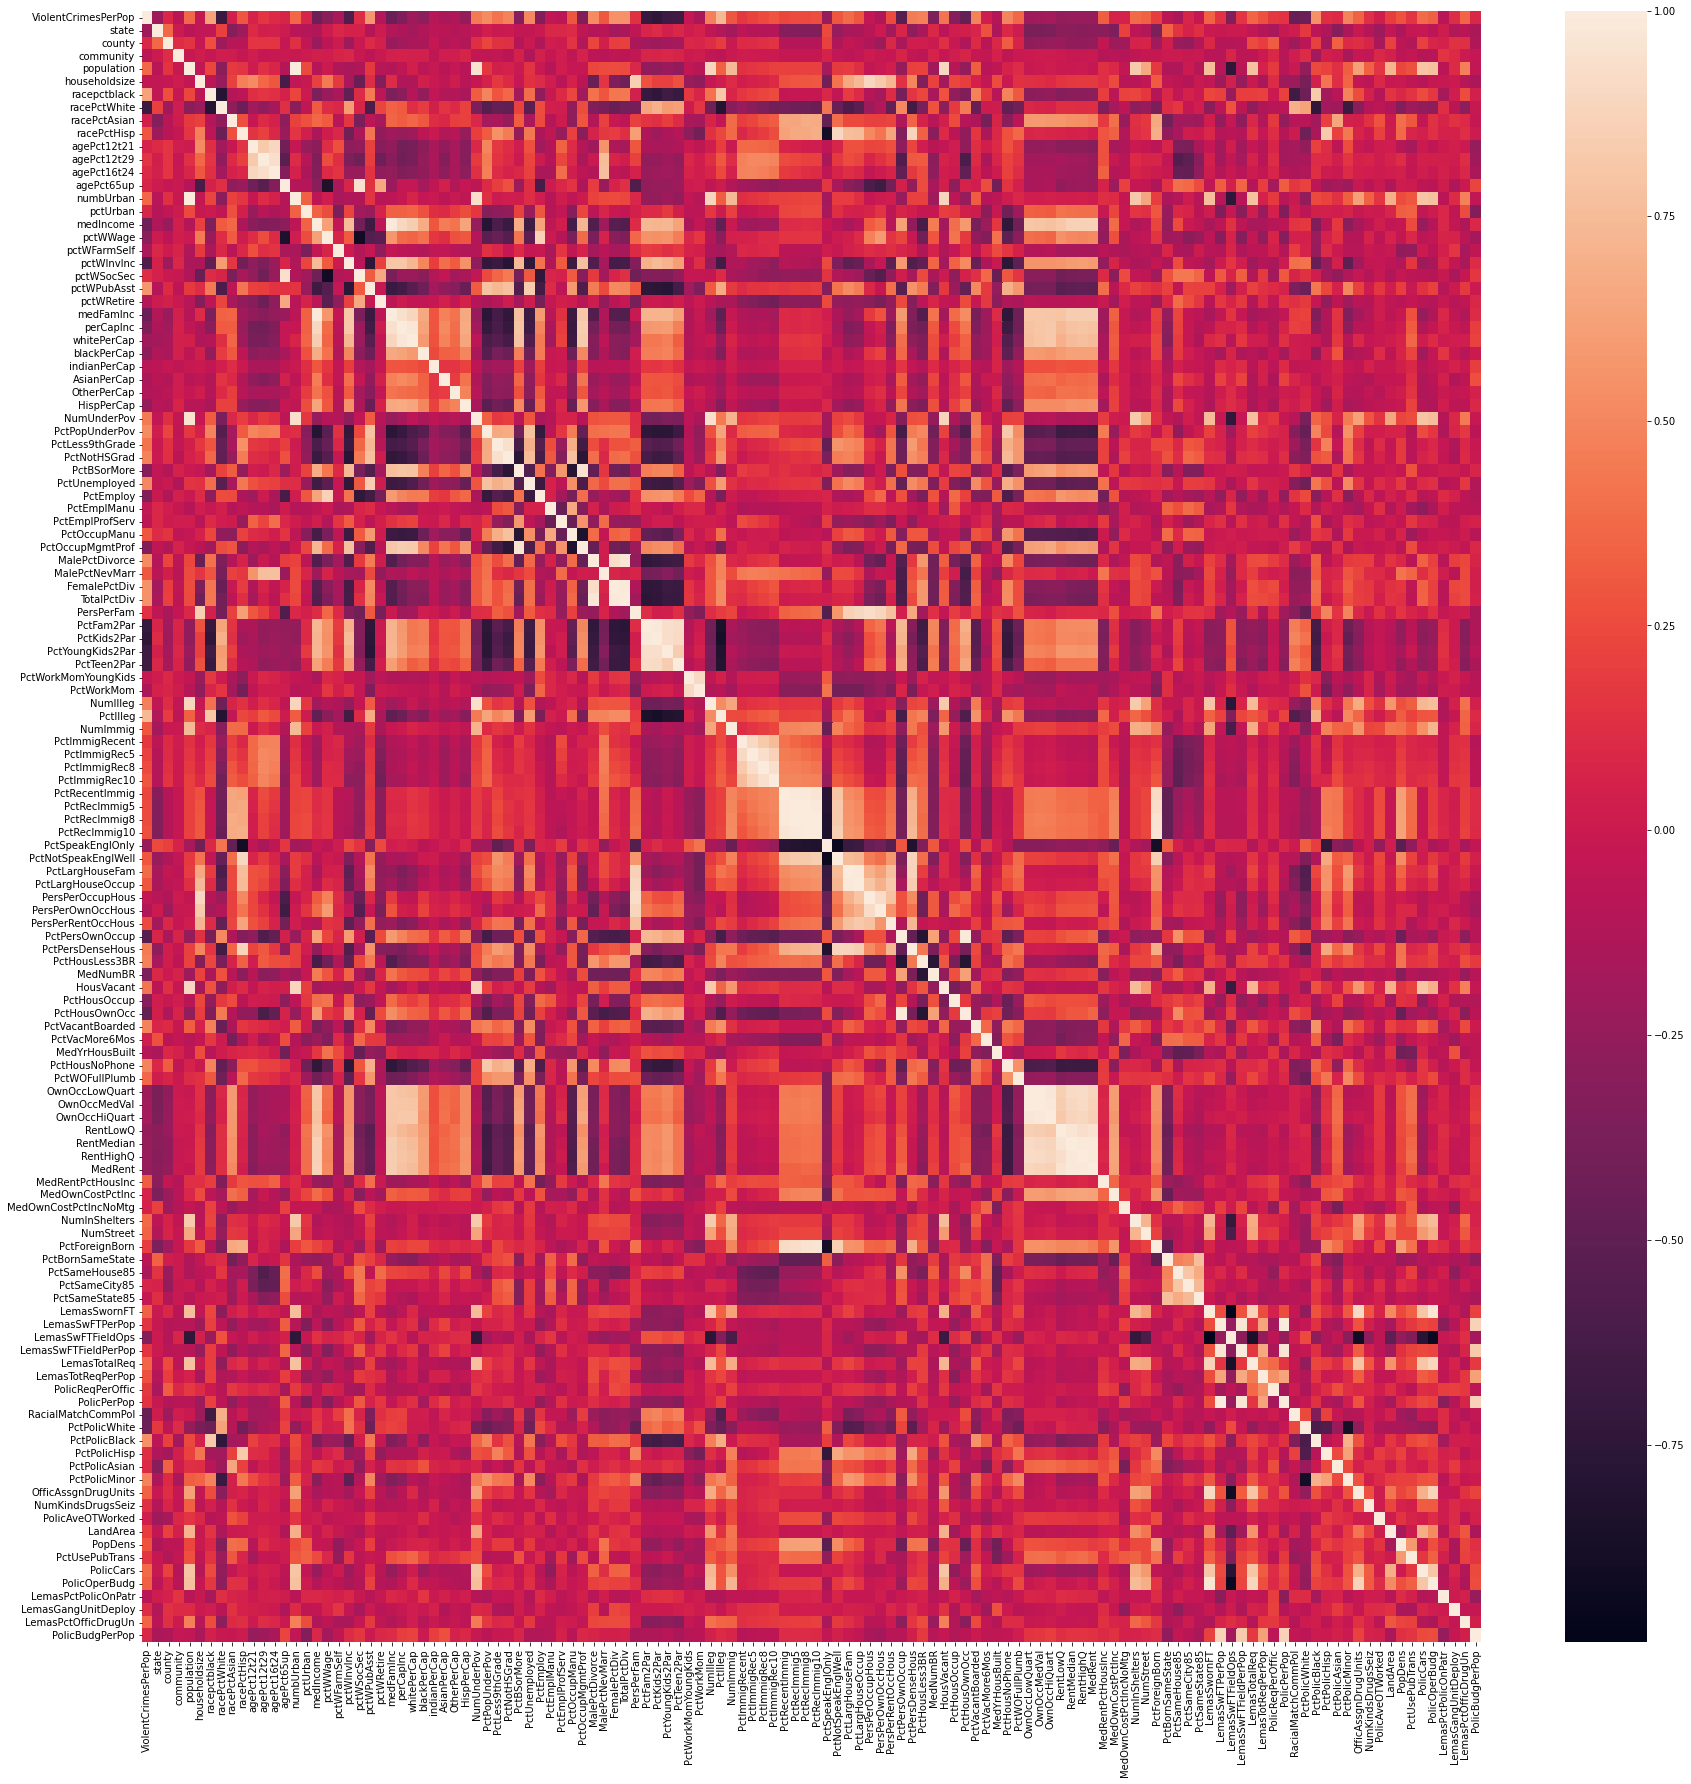

In [ ]:
# Feature correlation plot

plt.figure(figsize=(30, 30))
sns.heatmap(df.corr(), annot=False);

In [ ]:
# Get correlation between target variable and all features, sorted in 
# descending order

df_corr = df.corr()['ViolentCrimesPerPop'].reset_index().copy()
df_corr.columns = ['feature', 'correlation']
df_corr['abs_correlation'] = abs(df_corr['correlation'])
df_corr.sort_values(by='abs_correlation', ascending=False, inplace=True, ignore_index=True)
df_corr.drop(0, inplace=True) # Target variable's correlation with itself
df_corr

,feature,correlation,abs_correlation
1,PctKids2Par,-0.738424,0.738424
2,PctIlleg,0.737957,0.737957
3,PctFam2Par,-0.706667,0.706667
4,racePctWhite,-0.684770,0.684770
5,PctYoungKids2Par,-0.666059,0.666059
...,...,...,...
121,householdsize,-0.034923,0.034923
122,PolicAveOTWorked,0.033630,0.033630
123,PctWorkMomYoungKids,-0.022535,0.022535
124,PctVacMore6Mos,0.021283,0.021283


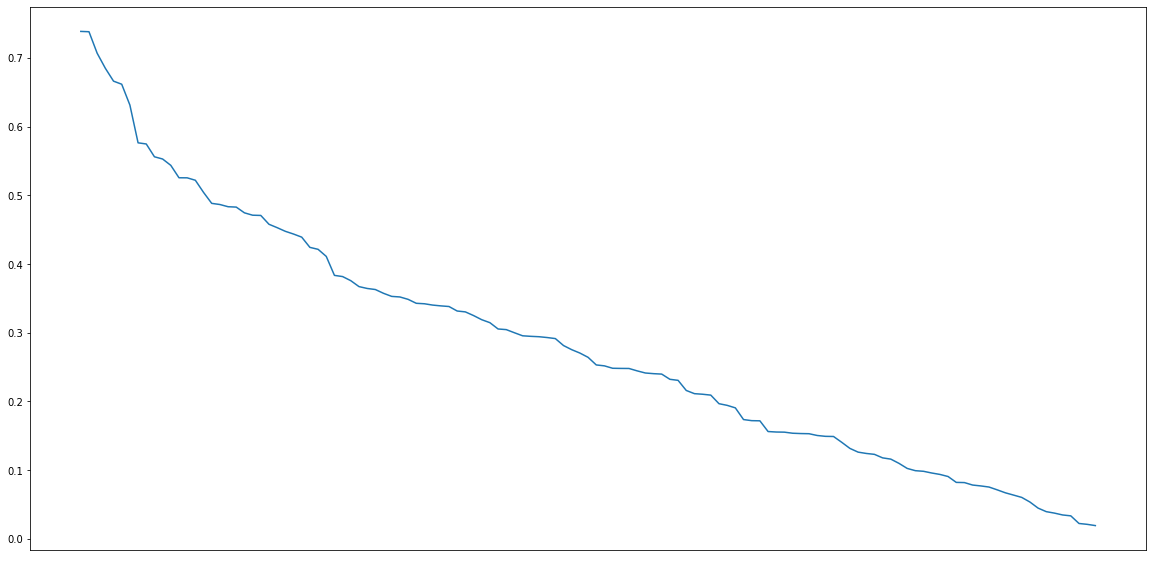

In [ ]:
# Plot correlation in descending order

plt.figure(figsize=[20,10])
plt.plot(df_corr['feature'], df_corr['abs_correlation'])
plt.xticks([]);

In [ ]:
# Most highly correlated features with absolute correlation coefficient over 0.5
# NOTE: Some of them are directly proportional while others are inversely 
# proportional to the target variable

df_corr[df_corr['abs_correlation'] > 0.5]

,feature,correlation,abs_correlation
1,PctKids2Par,-0.738424,0.738424
2,PctIlleg,0.737957,0.737957
3,PctFam2Par,-0.706667,0.706667
4,racePctWhite,-0.684770,0.684770
5,PctYoungKids2Par,-0.666059,0.666059
6,PctTeen2Par,-0.661582,0.661582
7,racepctblack,0.631264,0.631264
8,pctWInvInc,-0.576324,0.576324
9,pctWPubAsst,0.574665,0.574665
10,FemalePctDiv,0.556032,0.556032


# Preprocessing

In [ ]:
# Features with missing values

df.isna().sum().loc[lambda x: x>0]

county                  1174
community               1177
OtherPerCap                1
LemasSwornFT            1675
LemasSwFTPerPop         1675
LemasSwFTFieldOps       1675
LemasSwFTFieldPerPop    1675
LemasTotalReq           1675
LemasTotReqPerPop       1675
PolicReqPerOffic        1675
PolicPerPop             1675
RacialMatchCommPol      1675
PctPolicWhite           1675
PctPolicBlack           1675
PctPolicHisp            1675
PctPolicAsian           1675
PctPolicMinor           1675
OfficAssgnDrugUnits     1675
NumKindsDrugsSeiz       1675
PolicAveOTWorked        1675
PolicCars               1675
PolicOperBudg           1675
LemasPctPolicOnPatr     1675
LemasGangUnitDeploy     1675
PolicBudgPerPop         1675
dtype: int64

In [ ]:
# 1675 missing values implies 84% of values are not available. Imputing such a
# large number of values will lead to high bias within the data. Therefore, we 
# will remove these features from consideration

df.drop(list(df.isna().sum().loc[lambda x: x==1675].index), axis=1, inplace=True)
df.shape

(1994, 105)

In [ ]:
# OtherPerCap has only 1 missing value

df['OtherPerCap'].describe()

count    1993.000000
mean        0.284742
std         0.191008
min         0.000000
25%         0.170000
50%         0.250000
75%         0.360000
max         1.000000
Name: OtherPerCap, dtype: float64

In [ ]:
# OtherPerCap has low correlation with target variable

df_corr[df_corr['feature'] == 'OtherPerCap']

,feature,correlation,abs_correlation
96,OtherPerCap,-0.126345,0.126345


In [ ]:
# OtherPerCap column is skewed towards smaller values, has a low correlation
# with target variable, and has only 1 missing value. Mean is sensitive to 
# outliers, therefore we can use the column median for imputation without
# majorly affecting the regression analysis later on. Another good option would
# be to use the k nearest neighbour technique.

df['OtherPerCap'].fillna(df['OtherPerCap'].median(), inplace=True)
df['OtherPerCap'].isna().sum()

0

In [ ]:
# communityname has no missing values

df['communityname'].isna().sum()

0

In [ ]:
# 'community' (code) has 1177 missing values, that is 59% missing values.
# 'community' gives code for the community, while 'communityname' gives its name.
# 'communityname' doesn't have any missing values. Therefore, we can drop 
# community without losing any information

df.drop(['community'], axis=1, inplace=True)
df.shape

(1994, 104)

In [ ]:
# Number of unique communitynames

df['communityname'].nunique()

1828

In [ ]:
# Due to the large number of unique community names, their value doesn't encode
# much information that would help in the regression. Therefore, we will drop it.

df.drop(['communityname'], axis=1, inplace=True)
df.shape

(1994, 103)

In [ ]:
# 'county' has 1174 missing values, that is 59% missing values. It is a label,
# therefore imputing it's values wouldn't make sense. We also have 'state' which
# does provide similar information to some extent. Therefore, we will remove
# 'county' from consideration.

df.drop(['county'], axis=1, inplace=True)
df.shape

(1994, 102)

In [ ]:
# Encoding the 'state' feature

enc = OneHotEncoder()
df_state = pd.DataFrame(enc.fit_transform(df[['state']]).toarray())
df_state

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1991,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Low correlation between states and target variable

pd.concat([df[['ViolentCrimesPerPop']], df_state], axis=1).corr()['ViolentCrimesPerPop'].sort_values(ascending=False)

ViolentCrimesPerPop    1.000000
9                      0.205679
4                      0.159821
35                     0.127477
16                     0.120877
28                     0.108181
0                      0.099264
10                     0.086231
18                     0.080849
8                      0.073282
37                     0.035099
26                     0.032620
38                     0.021690
15                     0.021305
3                      0.021296
21                     0.014813
7                      0.012696
14                     0.011734
27                     0.010369
1                      0.000337
23                    -0.002578
2                     -0.004744
42                    -0.007358
20                    -0.007858
5                     -0.010052
41                    -0.014401
31                    -0.021300
43                    -0.021446
12                    -0.022237
45                    -0.029699
13                    -0.030024
11      

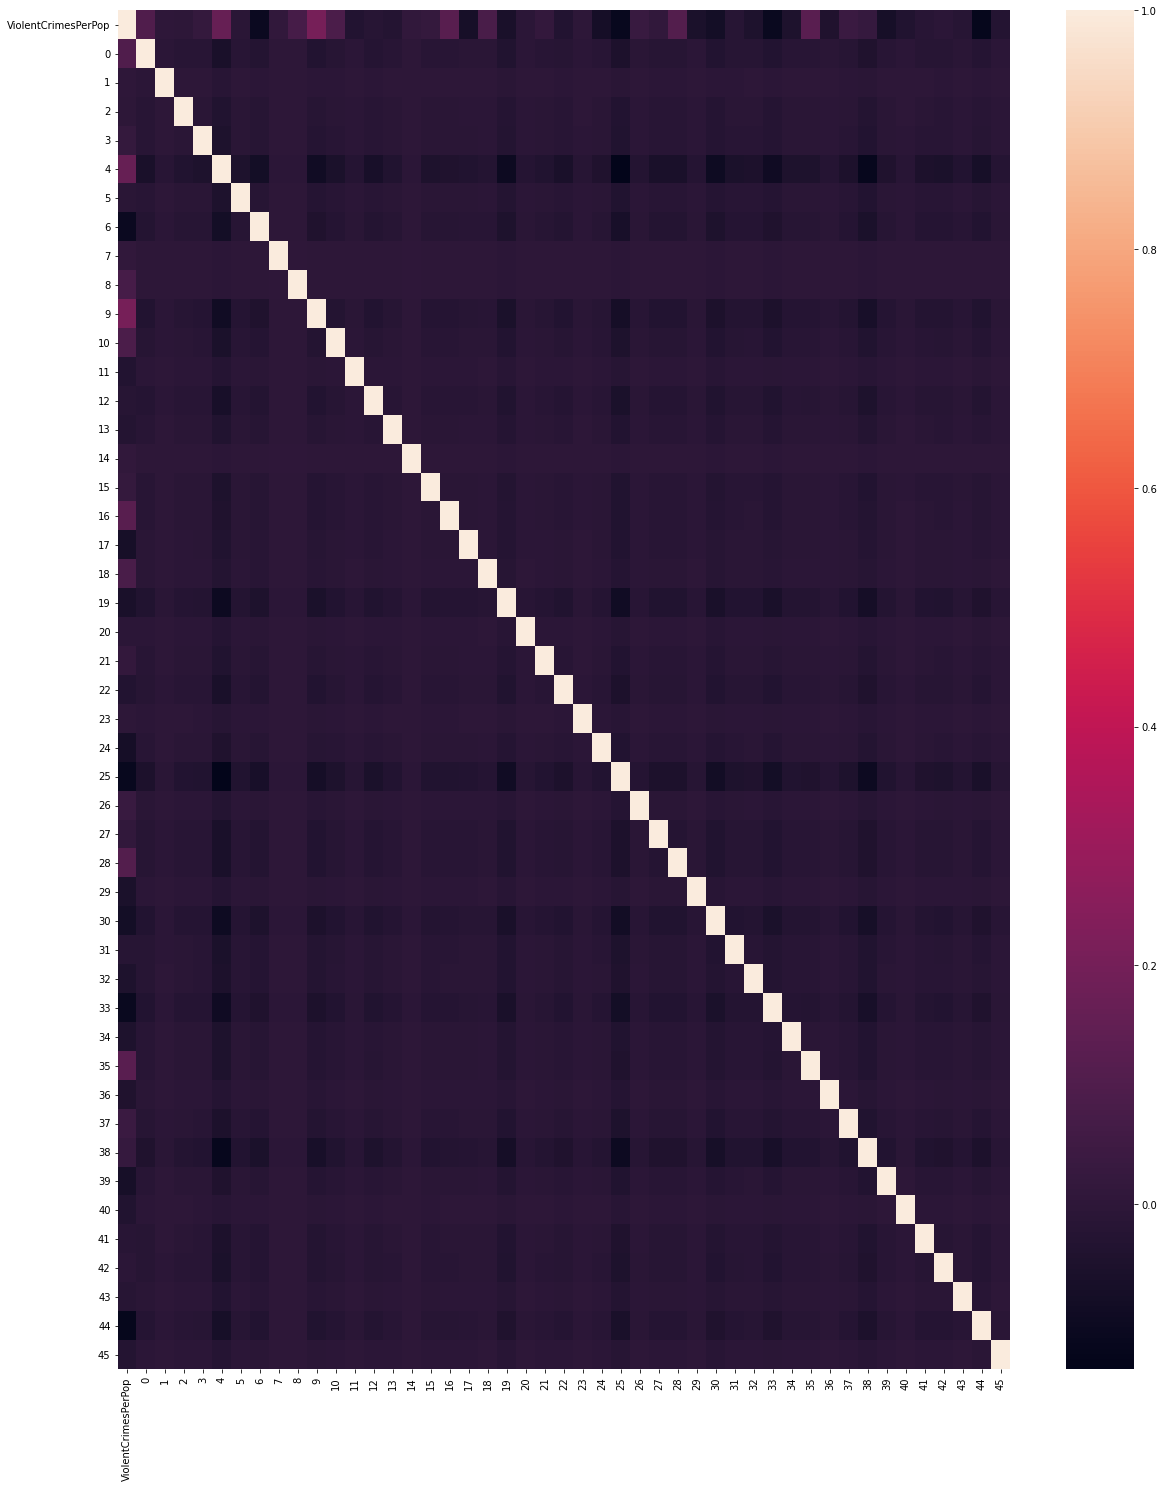

In [ ]:
plt.figure(figsize=(20, 25))
sns.heatmap(pd.concat([df[['ViolentCrimesPerPop']], df_state], axis=1).corr(), annot=False)

In [ ]:
# Due to the low correlation between 'state' and target variable, we will drop it.

df.drop(['state'], axis=1, inplace=True)
df.shape

(1994, 101)

# Train-test split

In [ ]:
# Train-test split for regression

X_train, X_test, Y_train, Y_test = train_test_split(df.drop('ViolentCrimesPerPop', axis=1), df[['ViolentCrimesPerPop']], test_size=0.2, random_state=42)
print('Mean of target variable in test set: %f' % Y_test.mean())
print('Median of target variable in test set: %f' % Y_test.median())

Mean of target variable in test set: 0.212180
Median of target variable in test set: 0.130000


# Regression using all 100 features

In [ ]:
# Linear Regression

kf = KFold(n_splits=5, random_state=None)
model =  LinearRegression()
result = cross_val_score(model , X_train, Y_train, scoring = 'neg_root_mean_squared_error', cv = kf)
print("Average cross-validation error: {}".format(-round(result.mean(), 3)))

Average cross-validation error: 0.14


In [ ]:
# Support Vector Regression using Grid Search

params = dict()
params['kernel'] = ['linear', 'poly', 'rbf']
params['C'] = [1, 10, 100]

kf = KFold(n_splits=5, random_state=None)
model =  SVR()
gs = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=kf)
result = gs.fit(X_train, Y_train)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Score: %s' % round(-result.best_score_, 3))

Best Hyperparameters: {'C': 1, 'kernel': 'linear'}
Best Score: 0.099


In [ ]:
# K Nearest Neighbors using Grid Search

params = dict()
params['n_neighbors'] = [5, 10, 20]
params['weights'] = ['uniform', 'distance']

kf = KFold(n_splits=5, random_state=None)
model =  KNeighborsRegressor()
gs = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=kf)
result = gs.fit(X_train, Y_train)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Score: %s' % round(-result.best_score_, 3))

Best Hyperparameters: {'n_neighbors': 10, 'weights': 'distance'}
Best Score: 0.1


In [ ]:
# Gradient Boosting using Grid Search

params = dict()
params['n_estimators'] = [100, 500]
params['max_depth'] = [3, 5]

kf = KFold(n_splits=5, random_state=None)
model =  GradientBoostingRegressor()
gs = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=kf)
result = gs.fit(X_train, Y_train)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Score: %s' % round(-result.best_score_, 3))

Best Hyperparameters: {'max_depth': 3, 'n_estimators': 100}
Best Score: 0.095


In [ ]:
# Multi Layer Perceptron using Grid Search

params = dict()
params['activation'] = ['relu', 'tanh', 'logistic']
params['early_stopping'] = [True, False]

kf = KFold(n_splits=5, random_state=None)
model =  MLPRegressor()
gs = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=kf)
result = gs.fit(X_train, Y_train)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Score: %s' % round(-result.best_score_, 3))

Best Hyperparameters: {'activation': 'relu', 'early_stopping': False}
Best Score: 0.096


In [ ]:
# Performance of best model on test set

model = GradientBoostingRegressor(max_depth=3, n_estimators=100)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print("Best model's root mean squared error: %f" % round(math.sqrt(mean_squared_error(Y_test, Y_pred)), 3))

Best model's root mean squared error: 0.138000


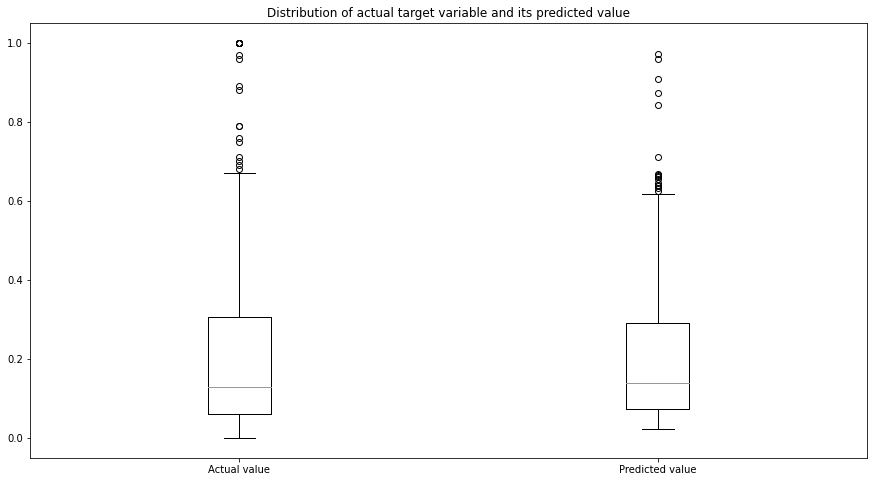

In [ ]:
# Plotting the result

plt.figure(figsize=[15,8])
plt.boxplot([Y_test['ViolentCrimesPerPop'], Y_pred], labels=['Actual value', 'Predicted value'])
plt.title('Distribution of actual target variable and its predicted value');

# Regression using dimensionality reduction on features

In [ ]:
# Dimensionality reduction
# We are left with 103 features, and 1994 samples (approximately 1:20 ratio)
# We can perform dimensionality reduction using PCA to get a smaller feature set.
# This way we do not lose information about less correlated features.

pca = PCA(n_components=26)
X_train_pca = pd.DataFrame(pca.fit_transform(X_train))
X_test_pca = pd.DataFrame(pca.transform(X_test))

In [ ]:
# Linear Regression

kf = KFold(n_splits=5, random_state=None)
model =  LinearRegression()
result = cross_val_score(model , X_train_pca, Y_train, scoring = 'neg_root_mean_squared_error', cv = kf)
print("Average cross-validation error: {}".format(-round(result.mean(), 3)))

Average cross-validation error: 0.142


In [ ]:
# Support Vector Regression using Grid Search

params = dict()
params['kernel'] = ['linear', 'poly', 'rbf']
params['C'] = [1, 10, 100]

kf = KFold(n_splits=5, random_state=None)
model =  SVR()
gs = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=kf)
result = gs.fit(X_train_pca, Y_train)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Score: %s' % round(-result.best_score_, 3))

Best Hyperparameters: {'C': 10, 'kernel': 'linear'}
Best Score: 0.099


In [ ]:
# K Nearest Neighbors using Grid Search

params = dict()
params['n_neighbors'] = [5, 10, 20]
params['weights'] = ['uniform', 'distance']

kf = KFold(n_splits=5, random_state=None)
model =  KNeighborsRegressor()
gs = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=kf)
result = gs.fit(X_train_pca, Y_train)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Score: %s' % round(-result.best_score_, 3))

Best Hyperparameters: {'n_neighbors': 10, 'weights': 'distance'}
Best Score: 0.1


In [ ]:
# Gradient Boosting using Grid Search

params = dict()
params['n_estimators'] = [100, 500]
params['max_depth'] = [3, 5]

kf = KFold(n_splits=5, random_state=None)
model =  GradientBoostingRegressor()
gs = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=kf)
result = gs.fit(X_train_pca, Y_train)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Score: %s' % round(-result.best_score_, 3))

Best Hyperparameters: {'max_depth': 3, 'n_estimators': 100}
Best Score: 0.101


In [ ]:
# MLP using Grid Search

params = dict()
params['activation'] = ['relu', 'tanh', 'logistic']
params['early_stopping'] = [True, False]

kf = KFold(n_splits=5, random_state=None)
model =  MLPRegressor()
gs = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=kf)
result = gs.fit(X_train_pca, Y_train)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Score: %s' % round(-result.best_score_, 3))

Best Hyperparameters: {'activation': 'logistic', 'early_stopping': False}
Best Score: 0.1


In [ ]:
# Performance of best model on test set

model =  SVR(C=10, kernel='linear')
model.fit(X_train_pca, Y_train)
Y_pred = model.predict(X_test_pca)
print("Root mean squared error on text set: %f" % round(math.sqrt(mean_squared_error(Y_test, Y_pred)), 3))

Root mean squared error on text set: 0.132000


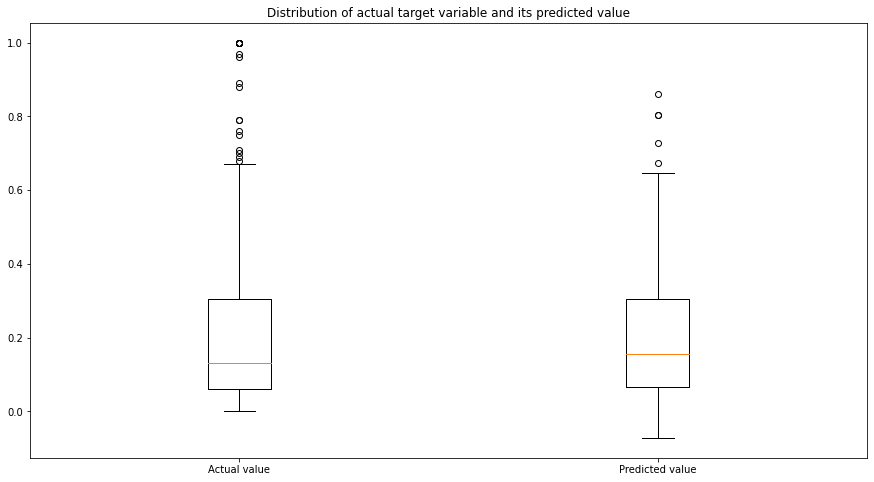

In [ ]:
# Plotting the result

plt.figure(figsize=[15,8])
plt.boxplot([Y_test['ViolentCrimesPerPop'], Y_pred], labels=['Actual value', 'Predicted value'])
plt.title('Distribution of actual target variable and its predicted value');

# Regression using feature selection based on correlation coefficient

In [ ]:
# Post-preprocessing correlation

df_corr = pd.concat([X_train, Y_train], axis=1).corr()['ViolentCrimesPerPop'].reset_index().copy()
df_corr.columns = ['feature', 'correlation']
df_corr['abs_correlation'] = abs(df_corr['correlation'])
df_corr.sort_values(by='abs_correlation', ascending=False, inplace=True, ignore_index=True)
df_corr.drop(0, inplace=True) # Target variable's correlation with itself
df_corr

,feature,correlation,abs_correlation
1,PctIlleg,0.740827,0.740827
2,PctKids2Par,-0.740630,0.740630
3,PctFam2Par,-0.711932,0.711932
4,racePctWhite,-0.676046,0.676046
5,PctYoungKids2Par,-0.671895,0.671895
...,...,...,...
96,agePct12t21,0.044827,0.044827
97,racePctAsian,0.033635,0.033635
98,PctVacMore6Mos,0.026820,0.026820
99,PctWorkMomYoungKids,-0.020879,0.020879


In [ ]:
# Feature selection:
# We are left with 100 features, and 1994 samples (approximately 1:20 ratio)
# We can select the most highly correlated features to the target variable, with
# correlation coefficient greater than 0.4, that is 26 features.

cols_high_corr = list(df_corr[df_corr['abs_correlation'] > 0.4]['feature'])
X_train_corr = X_train[cols_high_corr]
X_test_corr = X_test[cols_high_corr]

In [ ]:
# Linear Regression

kf = KFold(n_splits=5, random_state=None)
model =  LinearRegression()
result = cross_val_score(model , X_train_corr, Y_train, scoring = 'neg_root_mean_squared_error', cv = kf)
print("Average cross validation error: {}".format(round(-result.mean(), 3)))

Average cross validation error: 0.141


In [ ]:
# Support Vector Regression using Grid Search

params = dict()
params['kernel'] = ['linear', 'poly', 'rbf']
params['C'] = [1, 10, 100]

kf = KFold(n_splits=5, random_state=None)
model =  SVR()
gs = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=kf)
result = gs.fit(X_train_corr, Y_train)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Score: %s' % round(-result.best_score_, 3))

Best Hyperparameters: {'C': 1, 'kernel': 'linear'}
Best Score: 0.098


In [ ]:
# K Nearest Neighbors using Grid Search

params = dict()
params['n_neighbors'] = [5, 10, 20]
params['weights'] = ['uniform', 'distance']

kf = KFold(n_splits=5, random_state=None)
model =  KNeighborsRegressor()
gs = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=kf)
result = gs.fit(X_train_corr, Y_train)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Score: %s' % round(-result.best_score_, 3))

Best Hyperparameters: {'n_neighbors': 20, 'weights': 'distance'}
Best Score: 0.095


In [ ]:
# Gradient Boosting using Grid Search

params = dict()
params['n_estimators'] = [100, 500]
params['max_depth'] = [3, 5]

kf = KFold(n_splits=5, random_state=None)
model =  GradientBoostingRegressor()
gs = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=kf)
result = gs.fit(X_train_corr, Y_train)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Score: %s' % round(-result.best_score_, 3))

Best Hyperparameters: {'max_depth': 3, 'n_estimators': 100}
Best Score: 0.097


In [ ]:
# MLP using Grid Search

params = dict()
params['activation'] = ['relu', 'tanh', 'logistic']
params['early_stopping'] = [True, False]

kf = KFold(n_splits=5, random_state=None)
model =  MLPRegressor()
gs = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=kf)
result = gs.fit(X_train_corr, Y_train)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Score: %s' % round(-result.best_score_, 3))

Best Hyperparameters: {'activation': 'relu', 'early_stopping': True}
Best Score: 0.096


In [ ]:
# Performance of Linear Regression on test set

model = LinearRegression()
model.fit(X_train_corr, Y_train)
Y_pred = model.predict(X_test_corr)
print("Best model's root mean squared error: %f" % round(math.sqrt(mean_squared_error(Y_test, Y_pred)), 3))

Best model's root mean squared error: 0.133000


In [ ]:
# Performance of SVR on test set

model = SVR(C=1, kernel='linear')
model.fit(X_train_corr, Y_train)
Y_pred = model.predict(X_test_corr)
print("Best model's root mean squared error: %f" % round(math.sqrt(mean_squared_error(Y_test, Y_pred)), 3))

Best model's root mean squared error: 0.132000


In [ ]:
# Performance of KNN on test set

model = KNeighborsRegressor(n_neighbors=20, weights='distance')
model.fit(X_train_corr, Y_train)
Y_pred = model.predict(X_test_corr)
print("Best model's root mean squared error: %f" % round(math.sqrt(mean_squared_error(Y_test, Y_pred)), 3))

Best model's root mean squared error: 0.134000


In [ ]:
# Performance of gradient boosting on test set

model = GradientBoostingRegressor(max_depth=3, n_estimators=100)
model.fit(X_train_corr, Y_train)
Y_pred = model.predict(X_test_corr)
print("Best model's root mean squared error: %f" % round(math.sqrt(mean_squared_error(Y_test, Y_pred)), 3))

Best model's root mean squared error: 0.138000


In [ ]:
# Performance of MLP on test set

model = MLPRegressor(activation='relu', early_stopping=True)
model.fit(X_train_corr, Y_train)
Y_pred = model.predict(X_test_corr)
print("Best model's root mean squared error: %f" % round(math.sqrt(mean_squared_error(Y_test, Y_pred)), 3))

Best model's root mean squared error: 0.133000


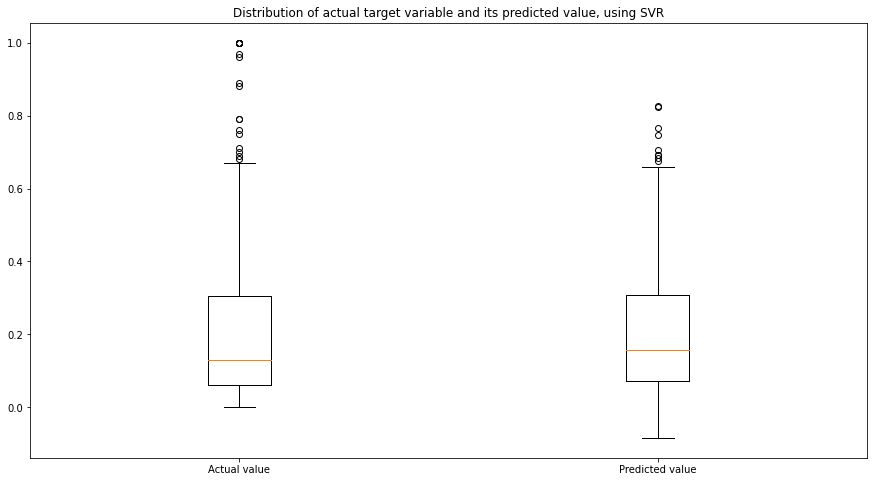

In [ ]:
# Plotting the result

plt.figure(figsize=[15,8])
plt.boxplot([Y_test['ViolentCrimesPerPop'], Y_pred], labels=['Actual value', 'Predicted value'])
plt.title('Distribution of actual target variable and its predicted value, using SVR');

# Analysis

Result analysis:
- Root mean squared errors are generally low due to normalized target variable.
- SVR, MLP and gradient boosting algorithms perform well with this data. Linear regression performs the worst and is too simple a model for this data.
- As expected, for different train-test sets, SVR worked best when using all 100 features for regression.
- Feature selection using correlation works best overall. However, it's performance worsens if the number of features is too low due to loss of important information within the smaller subset of features.
- For the dimensionality reduction case, as expected, SVR performs best when number of features is set higher, whereas MLP works better when number of features is set lower. Overall, dimensionality reduction using PCA gave the worst results among the three methods used.
- The algorithms perform decently on the test set but relatively poorly compared to the training set. Overall, I would choose SVR algorithm with feature selection based on correlation for regression on this dataset as it has consistently given the best performance over multiple iterations of regression.

Extending the regression analysis:
- Look further into multicollinearity, and further refine feature set by removing features with high collinearity. Also explore other methods of feature selection.
- More thorough grid search (or random search) for hyperparameters, and error analysis to compare the movement of training and testing errors.
- Increase number of splits in k-fold cross validation for more stable and consistent results.
- If possible, collect more data samples, and information on missing values. Plus work with unnormalized data.